## Tissue binary classifier 2

In this notebook i will try to have a different approach than binary_tissue_model notebook.  

**Main diff:**
- instead of one column describing Lung or Not Lung i will create a hot-encoded vector 
- Labels are [1,0] for lung and [0,1] for NOT_Lung
- Images will be organized in train and valid folder (NO class folder)
- Data will be loaded 'manually' in a list of [image, [label]]
- Images will be resized and converted in gray scale
- Precision and recall are calculated after fit on the validation set

**PROS**
- more control over the import process and labeling
- 2 neurons output layer
- faster because smaller images

**CONS**
- slower because all images are loaded simultaneously
- more manual process, risk of error

Ideas are coming from [here](https://towardsdatascience.com/image-classification-python-keras-tutorial-kaggle-challenge-45a6332a58b8)

**Questions**
- better normalize the whole dataset or batch by batch?

In [1]:
%matplotlib inline

from CMP_functions.preprocessing import *

import glob
import os
import random 

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K

Using TensorFlow backend.


## Data

In [2]:
PATH_info = '../data/images_info_table.csv'
PATH_img = '../data/images_jpeg/'
PATH_folders = '../classification_set/'

In [3]:
#load im info
info_df = pd.read_csv(PATH_info)

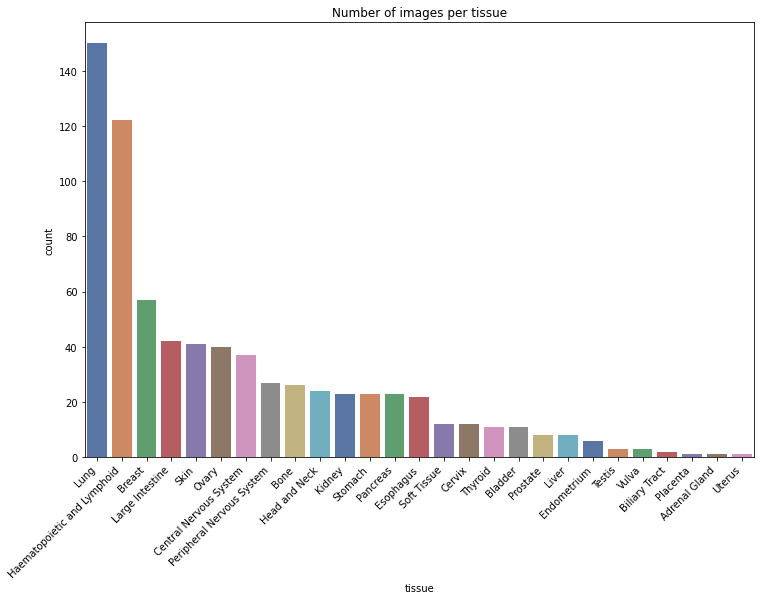

In [4]:
plot_ft_many(info_df, 'tissue')

In [5]:
#New column containig binary values for lung tissue
info_df['lung'] = np.where(info_df['tissue']=='Lung', '1', '0')

lung images = 150
NOT lung images = 586
negative-positive ratio = 3.9066666666666667


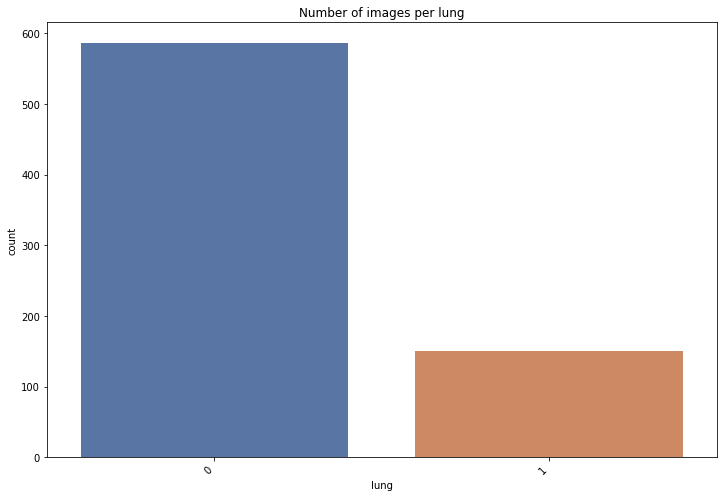

In [6]:
plot_ft_many(info_df, 'lung')
print(f'lung images =', len(info_df[info_df.lung=='1']))
print(f'NOT lung images =',len(info_df[info_df.lung=='0']))
print(f'negative-positive ratio =', len(info_df[info_df.lung=='0'])/len(info_df[info_df.lung=='1']))

In [7]:
im_lung_dict = dict(zip(info_df.im_id, info_df.lung))

In [8]:
# Check for images sizes and distribution of heights and widths

def get_size_statistics(DIR):
    heights = []
    widths = []
    for img in os.listdir(DIR):
        if '.jpg' in img:
            path = os.path.join(DIR, img)
            data = np.array(Image.open(path))
            heights.append(data.shape[0])
            widths.append(data.shape[1])

    return heights, widths

In [9]:
heights, widths = get_size_statistics(PATH_img)
    
avg_height = sum(heights) / len(heights)
avg_width = sum(widths) / len(widths)

print("Average Height: " + str(avg_height))
print("Max Height: " + str(max(heights)))
print("Min Height: " + str(min(heights)))
print('\n')
print("Average Width: " + str(avg_width))
print("Max Width: " + str(max(widths)))
print("Min Width: " + str(min(widths)))

Average Height: 1536.0
Max Height: 1536
Min Height: 1536


Average Width: 2048.0
Max Width: 2048
Min Width: 2048


In [10]:
IMG_SIZE = 300

All images are same size, i will resize them to 300x300

### Split of training a validation set

In [11]:
#here i split the dataset n train and validatio
split = 0.8
all_im = list(info_df.im_id)


#calculate size of positive and negative train and val sets
positive_train_size = round(len(info_df[info_df.lung=='1'])*split)
negative_train_size = round(len(info_df[info_df.lung=='0'])*split)

positive_validation_size = len(info_df[info_df.lung=='1']) - positive_train_size
negative_validation_size = len(info_df[info_df.lung=='0']) - negative_train_size

#randomly select images name

positive_train = random.sample(list(info_df.im_id[info_df.lung=='1']), positive_train_size)
negative_train = random.sample(list(info_df.im_id[info_df.lung=='0']), negative_train_size)

train_im = positive_train + negative_train
validation_im = [im for im in all_im if im not in train_im]

In [12]:
print ('ratio train set =',len(negative_train)/len(positive_train))

ratio train set = 3.908333333333333


## Import the dataset

In [13]:
def get_label(value):
    if value == '1':
        return [1,0]
    if value == '0':
        return [0,1]


def load_training_data(PATH_img,train_list, valid_list):
    train_data = []
    validation_data = []
    for img in os.listdir(PATH_img):
        if '.jpg' in img:
            #print ('name', img)
            im_name = img.split('.')[0]
            label = get_label(im_lung_dict[im_name])
            #print (im_name, label)            
            path = os.path.join(PATH_img, img)
            img = Image.open(path)
            # ANTIALAIS is a high-quality downsampling filter
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            # convert manually to gray scale (IS IT WORKING???)
            img = np.dot(np.array(img)[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)
            # rescale the value between 0 and 1
            img = np.divide(img, 255) 
            #if i visualise the image is not gray unless i set cmap = 'gray'
            #plt.imshow(img, cmap = 'gray')
            
            if im_name in train_list:
                train_data.append([img,label])
            
            if im_name in valid_list:
                validation_data.append([img,label])
                
    return train_data, validation_data

In [14]:
train_data, validation_data = load_training_data(PATH_img,train_im, validation_im)

In [15]:
trainImages = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
trainLabels = np.array([i[1] for i in train_data])

In [16]:
testImages = np.array([i[0] for i in validation_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
testLabels = np.array([i[1] for i in validation_data])

In [32]:
trainImages[0]

array([[[0.61960784],
        [0.61176471],
        [0.60392157],
        ...,
        [0.69019608],
        [0.70980392],
        [0.7254902 ]],

       [[0.62352941],
        [0.61960784],
        [0.60784314],
        ...,
        [0.66666667],
        [0.66666667],
        [0.6745098 ]],

       [[0.61568627],
        [0.60784314],
        [0.60784314],
        ...,
        [0.64705882],
        [0.65882353],
        [0.6627451 ]],

       ...,

       [[0.6745098 ],
        [0.6745098 ],
        [0.69803922],
        ...,
        [0.67058824],
        [0.66666667],
        [0.6627451 ]],

       [[0.67058824],
        [0.6745098 ],
        [0.69411765],
        ...,
        [0.66666667],
        [0.6627451 ],
        [0.65882353]],

       [[0.6745098 ],
        [0.67843137],
        [0.69803922],
        ...,
        [0.66666667],
        [0.6627451 ],
        [0.65490196]]])

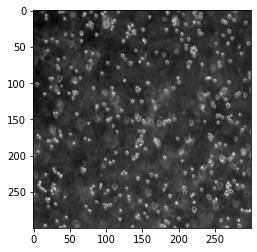

In [36]:
plt.imshow(trainImages[0].reshape(300,300), cmap = 'gray' )

In [31]:
trainLabels[0]

array([0, 1])

## Definition of the model

In [17]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2, activation = 'softmax'))

In [18]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))


# model.compile(optimizer="sgd",
#               loss="binary_crossentropy",
#               metrics=['accuracy', recall_m, precision_m, f1_m])

In [19]:
model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=['accuracy'])

## Training

In [20]:
history = model.fit(trainImages, trainLabels,
                    batch_size = 50,
                    epochs = 5,
                    validation_data= (testImages, testLabels),
                    verbose =1)


Train on 589 samples, validate on 147 samples
Epoch 1/5
589/589 [==============================] - 167s 283ms/step - loss: 0.7378 - accuracy: 0.6740 - val_loss: 0.6441 - val_accuracy: 0.7959
Epoch 2/5
589/589 [==============================] - 150s 255ms/step - loss: 0.4750 - accuracy: 0.7861 - val_loss: 0.5927 - val_accuracy: 0.7959
Epoch 3/5
589/589 [==============================] - 203s 345ms/step - loss: 0.3316 - accuracy: 0.8659 - val_loss: 0.5732 - val_accuracy: 0.7959
Epoch 4/5
589/589 [==============================] - 250s 425ms/step - loss: 0.2106 - accuracy: 0.9355 - val_loss: 0.5326 - val_accuracy: 0.7959
Epoch 5/5
589/589 [==============================] - 138s 235ms/step - loss: 0.1369 - accuracy: 0.9694 - val_loss: 0.5320 - val_accuracy: 0.7959


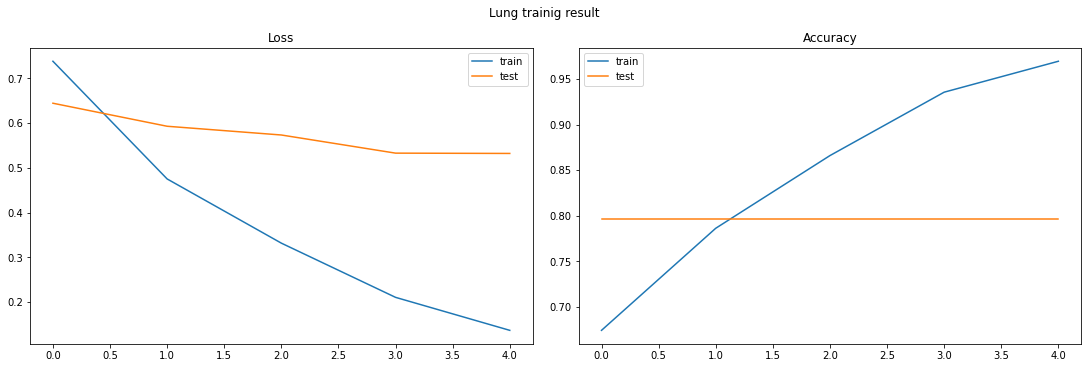

In [21]:
# fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows = 2, figsize=(15,5), constrained_layout=True,)
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5), constrained_layout=True,)

_ = fig.suptitle('Lung trainig result')

_ = ax1.set_title('Loss')
_ = ax1.plot(history.history['loss'], label='train')
_ = ax1.plot(history.history['val_loss'], label='test')
_ = ax1.legend()

_ = ax2.set_title('Accuracy')
_ = ax2.plot(history.history['accuracy'], label='train')
_ = ax2.plot(history.history['val_accuracy'], label='test')
_ = ax2.legend()

# _ = ax3.set_title('Precision')
# _ = ax3.plot(history.history['precision'], label='train')
# _ = ax3.plot(history.history['val_precision'], label='test')
# _ = ax3.legend()

# _ = ax4.set_title('Recall')
# _ = ax4.plot(history.history['recall'], label='train')
# _ = ax4.plot(history.history['val_recall'], label='test')
# _ = ax4.legend()

In [37]:
len(model.predict(testImages))

147

In [23]:
model.predict_proba(testImages)

array([[0.29806155, 0.70193845],
       [0.30886725, 0.6911328 ],
       [0.31035516, 0.6896448 ],
       [0.30797932, 0.69202065],
       [0.30985758, 0.69014245],
       [0.30566806, 0.69433194],
       [0.30654797, 0.69345194],
       [0.2981645 , 0.7018355 ],
       [0.30968425, 0.6903158 ],
       [0.30789465, 0.69210535],
       [0.30493554, 0.6950645 ],
       [0.3057007 , 0.69429934],
       [0.30191818, 0.6980818 ],
       [0.31314638, 0.68685365],
       [0.30611983, 0.6938802 ],
       [0.30831644, 0.69168353],
       [0.30215096, 0.69784904],
       [0.31811276, 0.6818872 ],
       [0.30529696, 0.6947031 ],
       [0.30361822, 0.6963818 ],
       [0.30364022, 0.6963598 ],
       [0.3012347 , 0.69876534],
       [0.304217  , 0.69578296],
       [0.30585784, 0.69414216],
       [0.30186802, 0.698132  ],
       [0.31713223, 0.68286777],
       [0.30016097, 0.69983906],
       [0.3057795 , 0.6942205 ],
       [0.30105925, 0.6989407 ],
       [0.30782422, 0.6921758 ],
       [0.

In [24]:
model.predict_classes(testImages)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])